In [2]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)          #some code samples return useless future warnings, this suppresses them

training = pd.read_csv("data/train_set.csv")
test = pd.read_csv("data/test_set.csv")
test.dropna(inplace=True)
test.drop(columns="Unnamed: 0",inplace=True)
training.drop(columns="Unnamed: 0",inplace=True)
training.dropna(inplace=True)

In [3]:
vals = [0]*len(training.columns)
for i,col in enumerate(training.columns):
    vals[i] = [col] + [list(training[col].unique())]
print(vals)

[['buying', ['low', 'vhigh', 'med', 'high']], ['maint', ['med', 'vhigh', 'low', 'high']], ['doors', ['3', '2', '5more', '4']], ['persons', ['4', '2', 'more']], ['lug_boot', ['small', 'med', 'big']], ['safety', ['high', 'low', 'med']], ['rating', ['good', 'unacc', 'vgood', 'acc']]]


In [4]:
subs = [['low','small','unacc','med','acc','big','high','good','vgood','vhigh','more','5more'],[0,0,0,1,1,2,2,2,3,3,5,5]]
training.replace(subs[0],subs[1],inplace=True)
test.replace(subs[0],subs[1],inplace=True)

for col in training.columns:
    training[col] = pd.to_numeric(training[col])
    test[col] = pd.to_numeric(test[col])

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
NFOLDS = 5
predictorCols = ['buying','maint','doors','persons','lug_boot','safety']
X = training[predictorCols]
y = training['rating']

nTrees = [n**2 for n in range(1,12)]
maxDepth = [None] + list(range(1,11))
maxFeaturesSplit = list(range(1,len(X.columns)))

searchParametersCoarse = {'n_estimators': nTrees[::3],'max_depth':maxDepth[::3],'max_features':maxFeatures[::3]}

skf = StratifiedKFold(n_splits = NFOLDS)
spaceSize = len(searchSpace)
accuracies = [0]*spaceSize
tempAcc = [0]*NFOLDS

for i, (trees, depth, maxFeatures) in enumerate(searchSpace):
    rfc = RandomForestClassifier(n_estimators=trees,max_depth=depth,max_features=maxFeatures)
    for j, (trainI, testI) in enumerate(skf.split(X, y)):
        Xtrain, Xtest = X.iloc[trainI], X.iloc[testI]
        ytrain, ytest = y.iloc[trainI], y.iloc[testI]
        rfc.fit(Xtrain,ytrain)
        tempAcc[j] = rfc.score(Xtest,ytest)
    accuracies[i] = sum(tempAcc)/NFOLDS
    print("\rProgress: "+str(i)+"/"+str(spaceSize),end='')



699

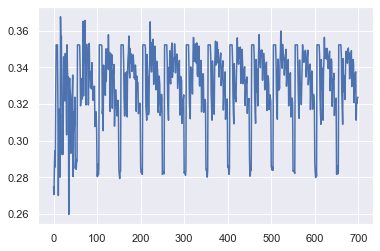

In [22]:
plt.plot(accuracies)
plt.show()

In [7]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
torch.cuda.is_available()

True